In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cairocffi as cairo

In [4]:
def circles_to_surface(circles, height, width):
    surface = cairo.ImageSurface(cairo.FORMAT_RGB24, width, height)
    context = cairo.Context(surface)
    
    context.set_source_rgba(1, 1, 1, 1)
    context.paint()
    
    sorted_circles = circles[circles[:, 2].argsort()]
    
    for circle in sorted_circles:
        context.set_source_rgba(circle[4], circle[5], circle[6], circle[7])
        context.arc(circle[0], circle[1], circle[3], 0, 2 * np.pi)
        context.fill()
    
    return surface

In [5]:
def circles_to_data(circles, height, width):
    return np.ndarray(shape=(height, width, 3), dtype=np.uint8,
                      buffer=circles_to_surface(circles, height, width).get_data())

In [6]:
def save_image(circles, height, width, filename):
    surface = circles_to_surface(circles, height, width)
    surface.write_to_png(filename)

In [7]:
def image_to_data(filename):
    surface = cairo.ImageSurface.create_from_png(filename)
    return np.array(np.ndarray(shape=(surface.get_height(), surface.get_width(), 3), dtype=np.uint8,
                      buffer=surface.get_data()[:]))

In [8]:
def distance(circles, original_image):
    test_image = circles_to_data(circles, original_image.shape[0], original_image.shape[1])
    difference = (original_image.astype(np.int16) - test_image).astype(np.int32)
    return 195075 * original_image.shape[0] * original_image.shape[1] - (difference ** 2).sum()

In [9]:
def test_function(circles, original_image_data):
    results = np.empty(circles.shape[0])
    for i in range(circles.shape[0]):
        results[i] = distance(circles[i, :, :], original_image_data)
    return results

Macież populacji ma wymiar n x k x 8, gdzie n jest liczbą osobników, k liczbą kółek, z których każde jest opisywane przez 8 wielkości:

x, y, z - współrzędne środka, trzeci wymiar jest potrzebny, ponieważ kółka mogą na siebie nachodzić,

r - długość promienia, (2 ** r)

_r, _g, _b - te wartości oznaczają kolor

_alpha - współczynnik intensywności

In [10]:
def mutation_swap_z(circles, probability):
    if np.random.random() > probability:
        return circles
    i = np.random.choice(circles.shape[0])
    j = np.random.choice(circles.shape[0])
    tmp = circles[i, 2]
    circles[i, 2] = circles[j, 2]
    circles[j, 2] = tmp
    return circles

In [11]:
def mutation_random_noise(circles, sigmas, probability):
    noise = sigmas * np.random.normal(size=circles.shape)
    if_mutated = ((np.random.random(size=circles.shape) - probability) < 0).astype(int)
    circles += if_mutated * noise
    return circles

In [12]:
def mutation_replace(circles, probability, begin_domain, end_domain):
    if np.random.random() > probability:
        return circles
    to_replace = np.random.choice(circles.shape[0])
    circles[to_replace] = begin_domain + (end_domain - begin_domain) * np.random.rand(8)
    return circles

In [13]:
def uniform_crossover(parents):
    take_from_0_to_0 = np.random.choice([True, False], size=parents.shape[1])
    take_from_1_to_0 = np.logical_not(take_from_0_to_0)

    child0 = np.vstack((parents[0][take_from_0_to_0], parents[1][take_from_1_to_0]))
    child1 = np.vstack((parents[1][take_from_0_to_0], parents[0][take_from_1_to_0]))

    return child0, child1

In [14]:
def random_population(population_size, number_of_circles, begin_domain, end_domain):
    return begin_domain + (end_domain - begin_domain) * np.random.rand(population_size, number_of_circles, 8)

In [15]:
def ES(population_size, number_of_circles, objective_function, begin_domain, end_domain,
       mutation1_probability, sigma_factor, mutation2_probability, mutation3_probability,
       number_of_offspring, crossover, number_of_iterations, new_min_z, new_max_z, new_max_r,
       start_population=None,log_frequency=None):
    
    best_solution = np.empty((number_of_circles, 8))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, number_of_circles, 8))
    log_best_sigmas = np.empty((number_of_iterations, number_of_circles, 8))

    # generating an initial population
    if start_population is not None:
        new_circles = number_of_circles - start_population.shape[1]
        current_population_solutions = np.hstack((start_population, random_population(population_size,
                                                                                      new_circles,
                                                                                      begin_domain,
                                                                                      end_domain)))

    else:
        current_population_solutions = random_population(population_size, number_of_circles,
                                                         begin_domain, end_domain)

    sigmas = sigma_factor * (end_domain - begin_domain)

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()

        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        
        parent_indices = np.random.choice(population_size, (number_of_offspring, 2),
                                          True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, number_of_circles, 8))

        for i in range(number_of_offspring // 2):
            children_population_solutions[2*i, :], children_population_solutions[2*i+1, :] = \
                                            crossover(current_population_solutions[parent_indices[i, :], :].copy())
        
        for i in range(children_population_solutions.shape[0]):
            children_population_solutions[i, :] = mutation_random_noise(children_population_solutions[i],
                                                                        sigmas, mutation1_probability)
        
        for i in range(children_population_solutions.shape[0]):
            children_population_solutions[i, :] = mutation_swap_z(children_population_solutions[i],
                                                                  mutation2_probability)
        
        for i in range(children_population_solutions.shape[0]):
            children_population_solutions[i, :] = mutation_replace(children_population_solutions[i],
                                                                  mutation3_probability,
                                                                  begin_domain, end_domain)
        
        clipped_solutions = np.clip(children_population_solutions, begin_domain, end_domain)
        children_population_solutions = 2 * clipped_solutions - children_population_solutions
        np.clip(children_population_solutions, begin_domain, end_domain, children_population_solutions)
        
        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)
        
        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values,
                                                         children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            save_image(best_solution, 552, 800, f'proby/{number_of_circles}_{t}.png')
            best_solution_objective_value = current_population_objective_values[0]
        
        log_objective_values[t, :] = [current_population_objective_values.min(),
                                      current_population_objective_values.max(),
                                      current_population_objective_values.mean(),
                                      current_population_objective_values.std()]
        
        log_best_solutions[t, :] = current_population_solutions[0, :]

        if log_frequency is not None and np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %d, mean score = %0.8f." % (t,
                                                                                log_objective_values[:t+1, 1].max(),
                                                                                log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, \
               log_best_solutions, current_population_solutions

In [16]:
begin_domain = np.array([0., 0., 0., 0., 0., 0., 0., 0.])
end_domain = np.array([800, 552, 10, 1200, 1., 1., 1., 1.])
mut1_prob = 0.3
mut2_prob = 0.
mut3_prob = 0.7
best = ES(50, 5, lambda c: test_function(c, image_to_data('mona_lisa.png')),
          begin_domain, end_domain, mut1_prob, 0.125, mut2_prob, mut3_prob, 500,
          uniform_crossover, 50, log_frequency=1)[1]
print(best)

Iteration 0000 : best score = 82540589222, mean score = 77903293622.50000000.
Iteration 0001 : best score = 82540589222, mean score = 77903293622.50000000.
Iteration 0002 : best score = 82540589222, mean score = 77903293622.50000000.
Iteration 0003 : best score = 84021274108, mean score = 83013435906.32000732.
Iteration 0004 : best score = 84059178952, mean score = 83806479306.47999573.
Iteration 0005 : best score = 84095671205, mean score = 84025540353.96000671.
Iteration 0006 : best score = 84152681922, mean score = 84070567315.08000183.
Iteration 0007 : best score = 84152681922, mean score = 84070567315.08000183.
Iteration 0008 : best score = 84191988097, mean score = 84106859964.17999268.
Iteration 0009 : best score = 84211611043, mean score = 84143892015.22000122.
Iteration 0010 : best score = 84233758104, mean score = 84162199695.30000305.
Iteration 0011 : best score = 84278083737, mean score = 84185914483.32000732.
Iteration 0012 : best score = 84293746290, mean score = 84213053

In [15]:
results_1 = np.empty((11, 5, 5))
for i in range(11):
    for j in range(5):
        for k in range(5):
            print(i, j, k)
            results_1[i][j][k] = ES(50, 5, lambda c: test_function(c, image_to_data('mona_lisa.png')),
                                  begin_domain, end_domain, i / 10., (j + 1) / 20., 0., 0., 500,
                                  uniform_crossover, 15)[0]

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
1 0 0
1 0 1
1 0 2
1 0 3
1 0 4
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 2 0
1 2 1
1 2 2
1 2 3
1 2 4
1 3 0
1 3 1
1 3 2
1 3 3
1 3 4
1 4 0
1 4 1
1 4 2
1 4 3
1 4 4
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 1 0
2 1 1
2 1 2
2 1 3
2 1 4
2 2 0
2 2 1
2 2 2
2 2 3
2 2 4
2 3 0
2 3 1
2 3 2
2 3 3
2 3 4
2 4 0
2 4 1
2 4 2
2 4 3
2 4 4
3 0 0
3 0 1
3 0 2
3 0 3
3 0 4
3 1 0
3 1 1
3 1 2
3 1 3
3 1 4
3 2 0
3 2 1
3 2 2
3 2 3
3 2 4
3 3 0
3 3 1
3 3 2
3 3 3
3 3 4
3 4 0
3 4 1
3 4 2
3 4 3
3 4 4
4 0 0
4 0 1
4 0 2
4 0 3
4 0 4
4 1 0
4 1 1
4 1 2
4 1 3
4 1 4
4 2 0
4 2 1
4 2 2
4 2 3
4 2 4
4 3 0
4 3 1
4 3 2
4 3 3
4 3 4
4 4 0
4 4 1
4 4 2
4 4 3
4 4 4
5 0 0
5 0 1
5 0 2
5 0 3
5 0 4
5 1 0
5 1 1
5 1 2
5 1 3
5 1 4
5 2 0
5 2 1
5 2 2
5 2 3
5 2 4
5 3 0
5 3 1
5 3 2
5 3 3
5 3 4
5 4 0
5 4 1
5 4 2
5 4 3
5 4 4
6 0 0
6 0 1
6 0 2
6 0 3
6 0 4
6 1 0
6 1 1
6 1 2
6 1 3
6 1 4
6 2 0
6 2 1
6 2 2
6 2 3
6 2 4
6 3 0
6 3 

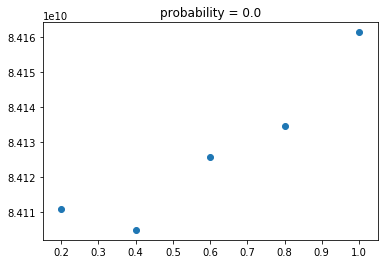

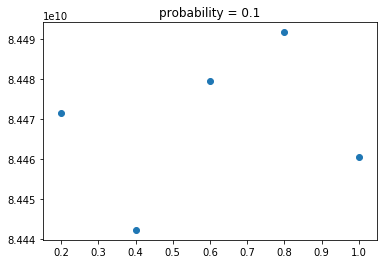

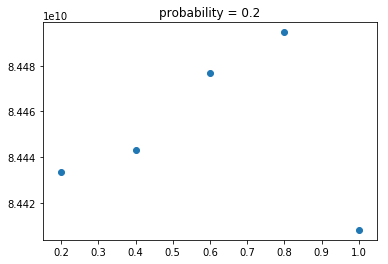

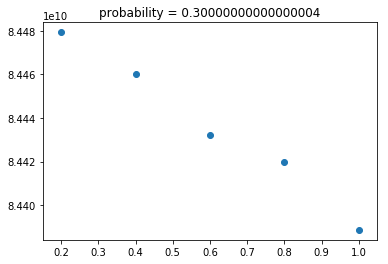

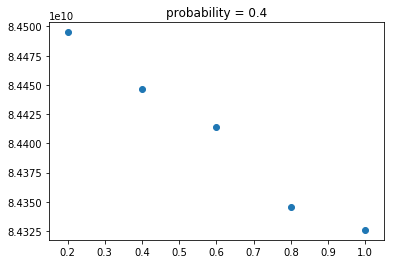

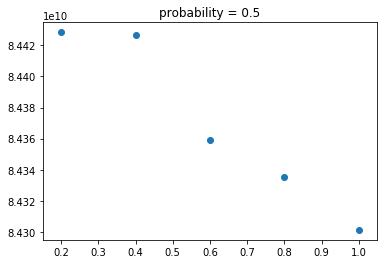

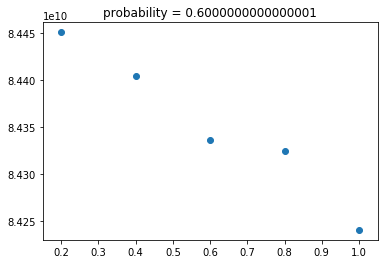

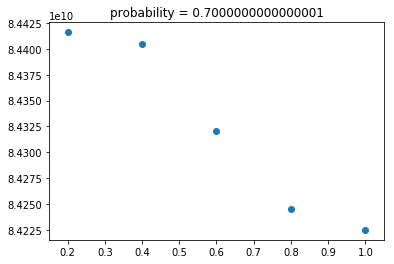

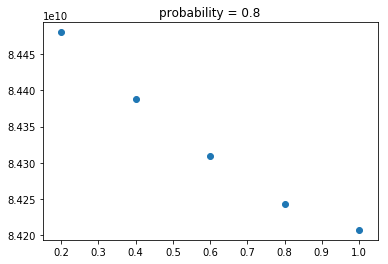

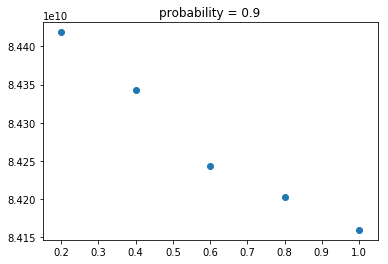

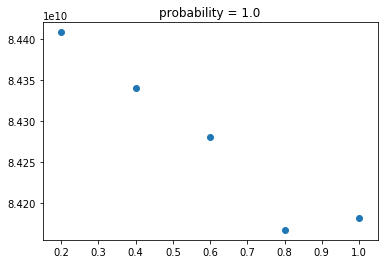

In [17]:
for i in range(results_1.shape[0]):
    plt.title("probability = " + str(i * 0.1))
    plt.scatter((np.arange(5) + 1) / 5., results_1.mean(axis=2)[i])
    plt.show()

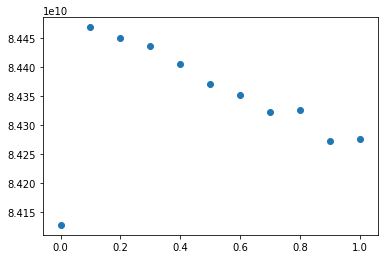

In [18]:
plt.scatter(np.arange(0., 1.1, 0.1), results_1.mean(axis=2).mean(axis=1))
plt.show()

In [31]:
results_1_1 = np.empty((10, 5))
for i in range(10):
    for j in range(5):
        print(i, j)
        results_1_1[i][j] = ES(50, 5, lambda c: test_function(c, image_to_data('mona_lisa.png')),
                               begin_domain, end_domain, 0.3, 0.2 * (i + 1) / 10, 0., 0., 500,
                               uniform_crossover, 10, log_frequency=10)[0]

0 0
Iteration 0000 : best score = 83581876140, mean score = 83122372164.03999329.
0 1
Iteration 0000 : best score = 83939135879, mean score = 83244977550.36000061.
0 2
Iteration 0000 : best score = 83861926038, mean score = 83346743202.38000488.
0 3
Iteration 0000 : best score = 83922009807, mean score = 83163714849.88000488.
0 4
Iteration 0000 : best score = 83951985491, mean score = 83386808914.53999329.
1 0
Iteration 0000 : best score = 84108380467, mean score = 83481546428.61999512.
1 1
Iteration 0000 : best score = 84013027722, mean score = 83159139027.11999512.
1 2
Iteration 0000 : best score = 84062898708, mean score = 83146134743.03999329.
1 3
Iteration 0000 : best score = 83875773678, mean score = 83059071819.10000610.
1 4
Iteration 0000 : best score = 83886193052, mean score = 83429856514.77999878.
2 0
Iteration 0000 : best score = 83953378474, mean score = 83142688207.72000122.
2 1
Iteration 0000 : best score = 83944868714, mean score = 83384802872.44000244.
2 2
Iteration 00

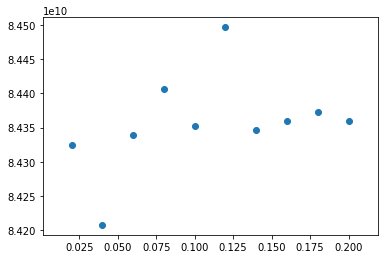

In [32]:
plt.scatter(np.arange(0.1, 1.1, 0.1) * 0.2, results_1_1.mean(axis=1))
plt.show()

In [25]:
results_2 = np.empty((11, 5))
for i in range(11):
    for j in range(5):
        print(i, j)
        results_2[i][j] = ES(50, 5, lambda c: test_function(c, image_to_data('mona_lisa.png')),
                             begin_domain, end_domain, 0., 1., i / 10., 0., 500, uniform_crossover, 10,
                             log_frequency=10)[0]

0 0
Iteration 0000 : best score = 83871023064, mean score = 83515622194.11999512.
0 1
Iteration 0000 : best score = 83822472458, mean score = 83253565000.63999939.
0 2
Iteration 0000 : best score = 83886813450, mean score = 83190380289.44000244.
0 3
Iteration 0000 : best score = 83885219114, mean score = 83318706343.38000488.
0 4
Iteration 0000 : best score = 83858434437, mean score = 82806317009.97999573.
1 0
Iteration 0000 : best score = 83988759755, mean score = 83279624800.97999573.
1 1
Iteration 0000 : best score = 83915648953, mean score = 83408310797.39999390.
1 2
Iteration 0000 : best score = 83845215450, mean score = 82842204341.25999451.
1 3
Iteration 0000 : best score = 83856957745, mean score = 83251297267.74000549.
1 4
Iteration 0000 : best score = 83915191306, mean score = 83198998130.30000305.
2 0
Iteration 0000 : best score = 84003090188, mean score = 82951359009.08000183.
2 1
Iteration 0000 : best score = 83847329570, mean score = 83085767968.97999573.
2 2
Iteration 00

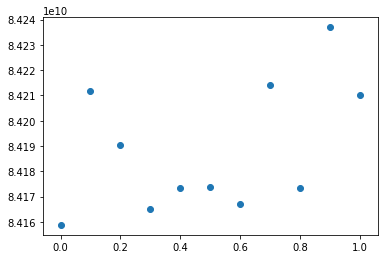

In [27]:
plt.scatter(np.arange(0., 1.1, 0.1), results_2.mean(axis=1))
plt.show()

In [29]:
results_3 = np.empty((11, 5))
for i in range(11):
    for j in range(5):
        print(i, j)
        results_3[i][j] = ES(50, 5, lambda c: test_function(c, image_to_data('mona_lisa.png')),
                             begin_domain, end_domain, 0., 1., 0., i / 10., 500, uniform_crossover, 10,
                             log_frequency=9)[0]

0 0
Iteration 0000 : best score = 83999873568, mean score = 83323010170.94000244.
Iteration 0009 : best score = 84174502438, mean score = 84174502438.00000000.
0 1
Iteration 0000 : best score = 83869781993, mean score = 83194870138.13999939.
Iteration 0009 : best score = 84139835170, mean score = 84139835170.00000000.
0 2
Iteration 0000 : best score = 83922780252, mean score = 83302959537.58000183.
Iteration 0009 : best score = 84218552888, mean score = 84218552888.00000000.
0 3
Iteration 0000 : best score = 84023847351, mean score = 83224916300.89999390.
Iteration 0009 : best score = 84152970337, mean score = 84152970337.00000000.
0 4
Iteration 0000 : best score = 83780616441, mean score = 83339844102.72000122.
Iteration 0009 : best score = 84019203054, mean score = 84019203054.00000000.
1 0
Iteration 0000 : best score = 83937802493, mean score = 83113557600.63999939.
Iteration 0009 : best score = 84331546560, mean score = 84316611419.77999878.
1 1
Iteration 0000 : best score = 839249

Iteration 0009 : best score = 84252213898, mean score = 84217701712.61999512.
10 2
Iteration 0000 : best score = 84029963339, mean score = 83172899148.25999451.
Iteration 0009 : best score = 84270618214, mean score = 84224841574.83999634.
10 3
Iteration 0000 : best score = 84066317394, mean score = 83304555095.69999695.
Iteration 0009 : best score = 84294439206, mean score = 84211835669.10000610.
10 4
Iteration 0000 : best score = 83781421170, mean score = 83041594865.89999390.
Iteration 0009 : best score = 84288380857, mean score = 84229990901.61999512.


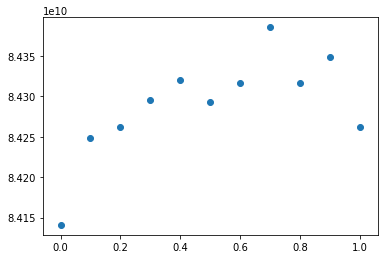

In [30]:
plt.scatter(np.arange(0., 1.1, 0.1), results_3.mean(axis=1))
plt.show()

In [23]:
number_of_circles = 0
current_population = None
while number_of_circles != 250:
    number_of_circles += 5
    obj_value, best, _, _, current_population = ES(50, number_of_circles,
                                                   lambda c: test_function(c, image_to_data('mona_lisa.png')),
                                                   begin_domain, end_domain, mut1_prob, 1., mut2_prob, mut3_prob,
                                                   500, uniform_crossover, 10, current_population, log_frequency=1)
save_image(best, 552, 800, 'result.png')

Iteration 0000 : best score = 54169428341, mean score = 54169409015.23999786.
Iteration 0001 : best score = 54169428341, mean score = 54169409015.23999786.
Iteration 0002 : best score = 54169438077, mean score = 54169423263.72000122.
Iteration 0003 : best score = 54169438077, mean score = 54169423263.72000122.
Iteration 0004 : best score = 54169438077, mean score = 54169427614.98000336.
Iteration 0005 : best score = 54169438077, mean score = 54169427614.98000336.
Iteration 0006 : best score = 54169438077, mean score = 54169427658.19999695.
Iteration 0007 : best score = 54169438077, mean score = 54169427658.19999695.
Iteration 0008 : best score = 54169439092, mean score = 54169431933.94000244.
Iteration 0009 : best score = 54169439092, mean score = 54169431933.94000244.
Iteration 0000 : best score = 54169430243, mean score = 54169419352.27999878.
Iteration 0001 : best score = 54169430243, mean score = 54169419352.27999878.
Iteration 0002 : best score = 54169430243, mean score = 54169422

Iteration 0006 : best score = 54169484842, mean score = 54169484842.00000000.
Iteration 0007 : best score = 54169484842, mean score = 54169484842.00000000.
Iteration 0008 : best score = 54169484842, mean score = 54169484842.00000000.
Iteration 0009 : best score = 54169484842, mean score = 54169484842.00000000.
Iteration 0000 : best score = 54169436077, mean score = 54169311112.80000305.
Iteration 0001 : best score = 83896859295, mean score = 83122588674.16000366.
Iteration 0002 : best score = 83976843970, mean score = 83595643403.94000244.
Iteration 0003 : best score = 83976843970, mean score = 83595643403.94000244.
Iteration 0004 : best score = 84058497209, mean score = 83733327315.52000427.
Iteration 0005 : best score = 84058497209, mean score = 83762350007.41999817.
Iteration 0006 : best score = 84058497209, mean score = 83762350007.41999817.
Iteration 0007 : best score = 84058497209, mean score = 83815983100.86000061.
Iteration 0008 : best score = 84058497209, mean score = 83868749

Iteration 0002 : best score = 84015489136, mean score = 83362237662.83999634.
Iteration 0003 : best score = 84015489136, mean score = 83362237662.83999634.
Iteration 0004 : best score = 84015489136, mean score = 83362237662.83999634.
Iteration 0005 : best score = 84065891321, mean score = 83601638975.97999573.
Iteration 0006 : best score = 84065891321, mean score = 83601638975.97999573.
Iteration 0007 : best score = 84065891321, mean score = 83720314508.25999451.
Iteration 0008 : best score = 84065891321, mean score = 83720314508.25999451.
Iteration 0009 : best score = 84065891321, mean score = 83774303010.08000183.
Iteration 0000 : best score = 54169589458, mean score = 54169589458.00000000.
Iteration 0001 : best score = 84020480818, mean score = 83071469869.00000000.
Iteration 0002 : best score = 84020480818, mean score = 83071469869.00000000.
Iteration 0003 : best score = 84029750414, mean score = 83508535932.97999573.
Iteration 0004 : best score = 84029750414, mean score = 83508535

Iteration 0008 : best score = 84165561179, mean score = 83880568577.52000427.
Iteration 0009 : best score = 84165561179, mean score = 83896084877.47999573.
Iteration 0000 : best score = 54169589458, mean score = 54169589458.00000000.
Iteration 0001 : best score = 83944424010, mean score = 83281555386.25999451.
Iteration 0002 : best score = 83944424010, mean score = 83523786328.74000549.
Iteration 0003 : best score = 83944424010, mean score = 83632778740.94000244.
Iteration 0004 : best score = 83944424010, mean score = 83713819404.94000244.
Iteration 0005 : best score = 83944424010, mean score = 83752152545.41999817.
Iteration 0006 : best score = 84003351973, mean score = 83777311634.24000549.
Iteration 0007 : best score = 84006750028, mean score = 83813562031.83999634.
Iteration 0008 : best score = 84006750028, mean score = 83824159862.86000061.
Iteration 0009 : best score = 84006750028, mean score = 83848704951.11999512.
Iteration 0000 : best score = 83953128067, mean score = 81091271

Iteration 0004 : best score = 83954238798, mean score = 83666677728.74000549.
Iteration 0005 : best score = 83981629530, mean score = 83723013326.74000549.
Iteration 0006 : best score = 83981629530, mean score = 83723013326.74000549.
Iteration 0007 : best score = 83981629530, mean score = 83749497770.80000305.
Iteration 0008 : best score = 84017367692, mean score = 83769032441.58000183.
Iteration 0009 : best score = 84017367692, mean score = 83802919959.60000610.
Iteration 0000 : best score = 83900504042, mean score = 83274200131.88000488.
Iteration 0001 : best score = 84003854033, mean score = 83575264577.02000427.
Iteration 0002 : best score = 84003854033, mean score = 83654442221.96000671.
Iteration 0003 : best score = 84041993844, mean score = 83724568053.77999878.
Iteration 0004 : best score = 84041993844, mean score = 83787149646.97999573.
Iteration 0005 : best score = 84041993844, mean score = 83833561094.05999756.
Iteration 0006 : best score = 84041993844, mean score = 83855237

new_z, new_max_r